### Patrick Horlaville (260931235) - Problem Set 3 - PHYS 512 : Computational Physics with Applications

Prof: Jon Sievers. TAs: Marcus Merryfield, Rigel Zifkin

In [43]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
import astropy.units as un

## Problem 1

We want to write an RK4 integrator to take one step to integrate the function:

In [ ]:
def fun(x,y):
    return y/(1 + x**2)

from x = -20 to x = 20 with y(-20) = 1 using 200 steps.

To do so, we can use code snippets from class. This integrator has 4 function calls, as pointed out in the comments:

In [4]:
def rk4_step(fun, x, y, h):


    k1 = h*fun(x, y)              # first
    k2 = h*fun(x + h/2, y + k1/2) # second
    k3 = h*fun(x + h/2, y + k2/2) # third
    k4 = h*fun(x + h, y + k3)     # fourth
    dy = (k1+ 2*k2 + 2*k3 + k4)/6
 
    return y + dy

Now we can just integrate over the desired interval, setting our initial y(-20) value. We compare with the actual solution, $y = c_0 \cdot exp(arctan(x))$, with $c_0 = exp(arctan(20))$ for our initial condition

In [29]:
x_1 = np.linspace(-20, 20, 200)
y_1 = np.zeros(len(x))

In [33]:
x_1 = np.linspace(-20, 20, 200)
y_1 = np.zeros(len(x_1))
h_1 = x_1[1] - x_1[0]
y_1[0] = 1 

for i in range(len(x_1) - 1):
    y_1[i + 1] = rk4_step(fun, x_1[i], y_1[i], h_1)

y_act1 = np.exp(np.arctan(x_1) + np.arctan(20))
error_1 = np.abs(np.std(y_1 - y_act))

In [13]:
print('For our first integrator, using 200 points and 796 function calls, the error is', error_1)

For our first integrator, using 200 points and 796 function calls, the error is 0.00012017072311111393


Now we build our second integrator, which computes the integration with a full step h (just like our first integrator), and also the integration with a half-step h/2. This integrator has 11 function calls, as pointed out in the comments. We then compare the results from both integrations to cancel out the leading order truncation term in the Taylor series' expansion, as described in the PDF [from Numerical Recipes]

In [42]:
def rk4_stepd(fun, x, y, h):

    # y1
    k1 = h*fun(x,y)                   # first
    k2 = h*fun(x + h/2, y + k1/2)     # second
    k3 = h*fun(x + h/2, y + k2/2)     # third
    k4 = h*fun(x + h, y + k3)         # fourth
    dy = (k1 + 2*k2 + 2*k3 + k4)/6

    y1 = y + dy

    # y2: first half-step
    h_2 = h/2 
    k1 = k1/2  
    k2 = h_2*fun(x + h_2/2, y + k1/2) # fifth
    k3 = h_2*fun(x + h_2/2, y + k2/2) # sixth
    k4 = h_2*fun(x + h_2, y + k3)     # seventh
    dy = (k1+ 2*k2 + 2*k3 + k4)/6

    y2_h_2 = y + dy

    x = x + h_2
    y = y2_h_2

    # y2: second half step
    k1 = h_2*fun(x, y)                # eighth
    k2 = h_2*fun(x + h_2/2, y + k1/2) # ninth
    k3 = h_2*fun(x + h_2/2, y + k2/2) # tenth
    k4 = h_2*fun(x + h_2, y + k3)     # eleventh
    dy = (k1 + 2*k2 + 2*k3 + k4)/6

    y2 = y + dy
    delt = (y2 - y1)/15

    return y2 + delt 

Now we can compute the accuracy of this integrator, in a similar fashion as with our first integrator:

In [38]:
x_2 = np.linspace(-20, 20, 72)
y_2 = np.zeros(len(x_2))
h_1 = x_1[1] - x_1[0]
y_2[0] = 1

for i in range(len(x) - 1):
    y_2[i+1] = rk4_stepd(fun, x_1[i], y_2[i], h_1)

y_act2 = np.exp(np.arctan(x_2) + np.arctan(20))
error_2 = np.abs(np.std(y_2 - y_act2))

In [41]:
print('For our second integrator, using 72 points and 792 function calls, the error is', error_2)

For our second integrator, using 72 points and 792 function calls, the error is 2.394384673153139e-05


With our new estimate, our integrator is accurate to fifth order, just as predicted!

## Problem 2

a)

We would like to program the evolution of decay products from U238. First we need all decay products and their corresponding half-lives. In total, their are 14 decay products so 15 total products 

In [243]:
products = ['U238', 'T234', 'P234', 'U234', 'T230', 
            'R226', 'R222', 'Pol218', 'Plo214', 'B214', 
            'Pol214', 'Plo210', 'B210', 'Pol210', 'Plo206']

half_lives = [4.468e9*525600, 24.10*1440, 6.7*60, 
            245500*525600, 75380*525600, 1600*525600, 
            3.8235*1440, 3.10, 26.8, 19.9, 164.3/(6e7), 
            22.3*525600, 5015*525600, 138376*1440]

n = 15

We define the ODE that we will solve for. We have to consider how will each element's abundance evolve: the first one, U238, is the one decaying, so it strictly decays. The last one, Plo206, is stable, so it doesn't decay. All the other ones either decay or get contributions from the decay of other elements. We consider those three cases in our function:

In [82]:
def fun(t, N, half_life_arr = half_lives):
    
    n_elems = 15
    
    dNdt = np.zeros(n_elems)
    
    for i in range(n_elems):
        
        # First element
        if i == 0: 
            dNdt[i] = - N[i]/half_life_arr[i]
            
        # Last element
        elif i == n_elems - 1:
            dNdt[i] = N[i - 1]/half_life_arr[i - 1]

        # Middle elements 
        else: 
            dNdt[i] = N[i - 1]/half_life_arr[i - 1] - N[i]/half_life_arr[i]
    
    return dNdt*np.log(2)

Initiate decay: initial conditions are that there is 100% of U238 and no other elements.

In [71]:
N_0 = np.zeros(n)
N_0[0] = 1

We will integrate up to the half-life of U238:

In [77]:
t0 = 0
t1 = half_lives[0]

We can use a RK integrator with the 'Radau' method, it is convenient in dealing with stiff equations.

In [83]:
decay_products = integrate.solve_ivp(fun, [t0, t1], N_0, method = 'Radau')
N_1 = decay_products.y

We can now show the final elements' abundance after one U238 half-life:

In [104]:
for i in range(n):
    print(products[i],':', N_1[i, -1])

U238 : 0.5000006884950289
T234 : 7.388931085532596e-12
P234 : 8.559100669619099e-14
U234 : 2.7474689808351056e-05
T230 : 8.436159100069252e-06
R226 : 1.7906419996978036e-07
R222 : 1.1723492612775009e-12
Pol218 : 6.600777919373352e-16
Plo214 : 5.706478975458318e-15
B214 : 4.237273567597816e-15
Pol214 : 5.830687162113244e-22
Plo210 : 2.4957072995409117e-09
B210 : 5.612549845501219e-07
Pol210 : 4.2428455090597384e-08
Plo206 : 0.4999626154040582


Notice all abundances sum up to 1 approx. and U238 is down to 0.5 as expected

b)

i)

Now we would like to plot the ratio of Pb206 to U238 as a function of time. To do so we can twist our function from before but specifically for two elements:

In [128]:
def fun_alt(t, N, half_life):
    
    n_elems = 2

    dNdt = np.zeros(n_elems)
    dNdt[0] = - N[0]/half_life
    dNdt[1] = N[0]/half_life

    return dNdt*np.log(2)

Again, we take an initial sample of 100% U238 and we integrate up to one half-life of U238.

In [129]:
N_0 = np.array([1.0, 0.0])
t0 = 0
t1 = half_lives[0]

We write an intermediate function to be read by the scipy RK integrator:

In [178]:
def interm(t, N, half_life = half_lives[0]):
    return fun_alt(t, N, half_life)

In [179]:
decay_products_PB = integrate.solve_ivp(interm, [t0, t1], N_0, method = 'Radau', t_eval = np.linspace(0, t1, 500))
N_PB = decay_products_PB.y

We can compare our integration result with what the expected ratio would have been. That ratio should be $\frac{1- exp(- \lambda t)}{exp(- \lambda t)}$

In [180]:
t_PB = np.linspace(0, max(decay_products_PB.t), 500)
lam_PB = np.log(2)/half_lives[0]

real_ratio_PB = (1 - np.exp(- lam_PB*t_PB))/np.exp(- lam_PB*t_PB)
calc_ratio_PB = N_PB[1]/N_PB[0]

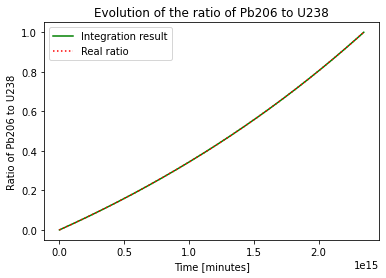

In [181]:
plt.plot(decay_products_PB.t, calc_ratio_PB, color = 'g', label = 'Integration result')
plt.plot(t_PB, real_ratio_PB, label = 'Real ratio', color = 'r', ls = ':')
plt.xlabel('Time [minutes]')
plt.ylabel('Ratio of Pb206 to U238')
plt.title('Evolution of the ratio of Pb206 to U238')
plt.legend()
plt.show()

We now perform a very similar task but with Th230 instead. This, time we integrate up until one half-life of Th230 (higher than U238! 14B against 4B years)

In [182]:
N_0 = np.array([1.0, 0.0])
t0 = 0
t2 = half_lives[4]

In [183]:
def interm_2(t, N, half_life = half_lives[4]):
    return fun_alt(t, N, half_life)

In [184]:
decay_products_TH = integrate.solve_ivp(interm_2, [t0, t2], N_0, method = 'Radau', t_eval = np.linspace(t0, t2, 500))
N_TH = decay_products_TH.y

Again, we can compare with the expected true evolution of this ratio:

In [185]:
t_TH = np.linspace(0, max(decay_products_TH.t), 500)
lam_TH = np.log(2)/half_lives[4]

real_ratio_TH = (1 - np.exp(- lam_TH*t_TH))/np.exp(- lam_TH*t_TH)
calc_ratio_TH = N_TH[1]/N_TH[0]

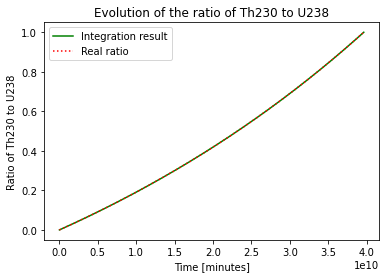

In [223]:
plt.plot(decay_products_TH.t, calc_ratio_TH, color = 'g', label = 'Integration result')
plt.plot(t_TH, real_ratio_TH, label = 'Real ratio', color = 'r', ls = ':')
plt.xlabel('Time [minutes]')
plt.ylabel('Ratio of Th230 to U238')
plt.title('Evolution of the ratio of Th230 to U238')
plt.legend()
plt.show()

So the integrator behaves reasonably well!

## Problem 3

b)

In a) [c.f. PDF], we found a net set of parameters that make the equation for z linear. Now we find the best fit parameters for the data from "dish_zenith.txt"

First, load data:

In [204]:
data = np.loadtxt('dish_zenith.txt')
x, y, z = data.T
print('There are', len(x), 'data points')

There are 475 data points


Second, we create our A matrix. Given our new expression for z, we just pick the factors of the different parameters:

In [205]:
A = np.zeros((475, 4))
A[:,0] = x**2 + y**2
A[:,1] = x
A[:,2] = y
A[:,3] = 1

Use SVD decomposition:

In [206]:
U, S, V_T = np.linalg.svd(A, False)

Invert S:

In [207]:
S_inv = np.asarray(np.diag(1.0/S))

Compute the parameters:

In [210]:
m = V_T.T@S_inv@U.T@z

a, alpha, beta, gamma = m

Which translate back to our old parameters as:

In [211]:
x0 = alpha/(-2*a)
y0 = beta/(-2*a)
z0 = gamma - a*x0**2 - a*y0**2 

In [222]:
print('We find:')
print('alpha =', alpha)
print('beta =', beta)
print('gamma =', gamma)
print('Or,')
print('x0 = ', x0)
print('y0 = ', y0)
print('z0 = ', z0)

We find:
alpha = 0.0004535990259733574
beta = -0.019411558866522054
gamma = -1512.3118166739066
Or,
x0 =  -1.3604886161809884
y0 =  58.22147612323479
z0 =  -1512.8772100375932


c)

Now we want to estimate the noise in the data, and from that, estimate the uncertainty on our parameters.

First, we can compute the residuals between our model and the data. We can approximate the error on the data to be the standard deviation of those residuals. If those residuals are approximately normally distributed, we can fairly assume that the noise is uncorrelated.

In [224]:
residuals = A@m - z
res_std = np.std(residuals)

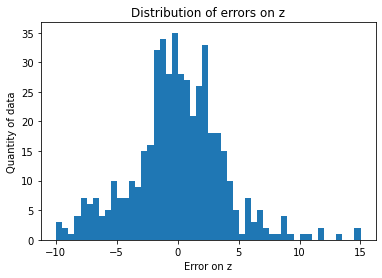

In [228]:
plt.hist(residuals, bins = 50)
plt.ylabel('Quantity of data')
plt.xlabel('Error on z')
plt.title('Distribution of errors on z')
plt.show()

We can reasonably say that the noise is uncorrelated. From that assumption, we can build our noise matrix and estimate the error on our parameters:

In [229]:
N = np.eye(475)*(res_std**2)

err_params = np.sqrt(np.diag(np.linalg.inv(A.T@(np.linalg.inv(N))@A)))

What would the error on the focal length be? Because $f = \frac{1}{4a}$, the relative error should be the same as $a$'s:

In [230]:
f = (1/(4*a))/1000
err_f = (f*err_params[0]/a)

In [242]:
print('Computed focal length f is', round(f, 4), '(+/-)', round(err_f, 4))

Computed focal length f is 1.4997 (+/-) 0.0006


Which is pretty close to our expected focal length of 1.5m